In [24]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score#, root_mean_squared_error

import matplotlib.pyplot as plt

In [33]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [146]:
xtrain_data = pd.read_csv(r'F:\Muthu_2023\Personal\Nextstep\PdM\Predictive-Maintenance\Datasets\ForModelDev\XTrain.csv')
ytrain_data = pd.read_csv(r'F:\Muthu_2023\Personal\Nextstep\PdM\Predictive-Maintenance\Datasets\ForModelDev\YTrain.csv')
engine_data = np.array(pd.read_csv(r'F:\Muthu_2023\Personal\Nextstep\PdM\Predictive-Maintenance\Datasets\ForModelDev\Engine.csv'))
xtest_data = pd.read_csv(r'F:\Muthu_2023\Personal\Nextstep\PdM\Predictive-Maintenance\Datasets\ForModelDev\XTest.csv')
ytest_data  = pd.read_csv(r'F:\Muthu_2023\Personal\Nextstep\PdM\Predictive-Maintenance\Datasets\ForModelDev\Ytest.csv')
engine_test_data = np.array(pd.read_csv(r'F:\Muthu_2023\Personal\Nextstep\PdM\Predictive-Maintenance\Datasets\ForModelDev\Engine_test.csv'))

In [147]:
def saturation_RUL(inp_df, th):
    temp_data = np.array(inp_df)
    temp_data[temp_data > th] = th
    return temp_data

In [148]:
threshold = 130
ytrain_data['Remaining Cycles'] = saturation_RUL(ytrain_data['Remaining Cycles'], threshold)
ytest_data['Remaining Cycles'] = saturation_RUL(ytest_data['Remaining Cycles'], threshold)
ytrain_data, ytest_data

(       Remaining Cycles
 0                   130
 1                   130
 2                   130
 3                   130
 4                   130
 ...                 ...
 20626                 4
 20627                 3
 20628                 2
 20629                 1
 20630                 0
 
 [20631 rows x 1 columns],
        Remaining Cycles
 0                   130
 1                   130
 2                   130
 3                   130
 4                   130
 ...                 ...
 13091                24
 13092                23
 13093                22
 13094                21
 13095                20
 
 [13096 rows x 1 columns])

In [65]:
# Training data transformation for LSTM
def Feature_Transform(xdata, engdata, window=30):
    n_samp = []
    engines = np.unique(engdata)
    for j in engines:
        local_df = xdata[engdata == j]
        num_samples = len(local_df) - window
        input_list = [np.expand_dims(np.atleast_2d(local_df.iloc[i:window+i,:]), axis=0) for i in range(num_samples)]
        if j == 1:
            input_mat = np.concatenate(input_list, axis=0)
        else:
            input_mat = np.concatenate([input_mat, np.concatenate(input_list, axis=0)], axis = 0)
        n_samp.append(num_samples)
    return input_mat, n_samp            

In [5]:
# RUL transformation for LSTM
def RUL_Transform(ydata, engdata, window=30):
    engines = np.unique(engdata)
    for j in engines:
        local_df = ydata[engdata == j]
        num_samples = len(local_df) - window
        input_list = [np.expand_dims(local_df.iloc[window+i], axis=0) for i in range(num_samples)]
        if j == 1:
            input_mat = np.concatenate(input_list, axis=0)
        else:
            input_mat = np.concatenate([input_mat, np.concatenate(input_list, axis=0)], axis = 0)
    return input_mat.flatten()

In [149]:
window = 30
xtrain, temp = Feature_Transform(xtrain_data.drop('Cycles', axis=1), engine_data, window)
ytrain = RUL_Transform(ytrain_data, engine_data, window)
xtrain.shape, ytrain.shape

((17631, 30, 12), (17631,))

In [150]:
xtest, n_samp = Feature_Transform(xtest_data.drop('Cycles', axis=1), engine_test_data, window)
ytest = RUL_Transform(ytest_data, engine_test_data, window)
xtest.shape, ytest.shape, len(n_samp)

((10096, 30, 12), (10096,), 100)

# LSTM

In [151]:
x_train, x_val, y_train, y_val = train_test_split(xtrain, ytrain, test_size=0.2, random_state = 83)
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)
features = xtrain.shape[2]

(14104, 30, 12) (3527, 30, 12) (14104,) (3527,)


In [152]:
model = Sequential([
    layers.LSTM(128, activation = 'tanh', input_shape = (window, features), return_sequences = True),
    layers.LSTM(64, activation = 'tanh', return_sequences = True),
    layers.LSTM(32, activation = 'tanh'),
    layers.Dense(96, activation = 'relu'),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(1),
])

In [153]:
model.compile(loss = 'mse', optimizer = Adam(learning_rate = 0.001))

In [154]:
history = model.fit(x_train, y_train, epochs = 10, validation_data = (x_val, y_val), batch_size = 128, verbose = 2)

Epoch 1/10
111/111 - 38s - loss: 3557.1123 - val_loss: 648.3138 - 38s/epoch - 339ms/step
Epoch 2/10
111/111 - 26s - loss: 293.5647 - val_loss: 197.6458 - 26s/epoch - 230ms/step
Epoch 3/10
111/111 - 25s - loss: 203.4290 - val_loss: 176.8013 - 25s/epoch - 224ms/step
Epoch 4/10
111/111 - 25s - loss: 178.7308 - val_loss: 153.1436 - 25s/epoch - 226ms/step
Epoch 5/10
111/111 - 22s - loss: 160.9475 - val_loss: 148.8528 - 22s/epoch - 199ms/step
Epoch 6/10
111/111 - 22s - loss: 148.2598 - val_loss: 153.4013 - 22s/epoch - 201ms/step
Epoch 7/10
111/111 - 22s - loss: 140.7628 - val_loss: 138.7427 - 22s/epoch - 198ms/step
Epoch 8/10
111/111 - 22s - loss: 127.5863 - val_loss: 115.4877 - 22s/epoch - 199ms/step
Epoch 9/10
111/111 - 22s - loss: 117.4237 - val_loss: 120.8294 - 22s/epoch - 201ms/step
Epoch 10/10
111/111 - 22s - loss: 106.9134 - val_loss: 103.5235 - 22s/epoch - 199ms/step


In [155]:
ypred = model.predict(xtest)

316/316 [==============================] - 10s 26ms/step


In [156]:
print('RMSE: ' + str(np.sqrt(mean_squared_error(ytest, ypred))))
print('R2: ' + str(r2_score(ytest, ypred)))

RMSE: 15.93609164450158
R2: 0.7448247250885693


In [157]:
wind = 1
n_samp = np.array(n_samp)
samp = {'n_samp': n_samp, 'cumulative':n_samp.cumsum(), 'windowed':n_samp.cumsum()-wind}
samp = pd.DataFrame(samp)
samp

,n_samp,cumulative,windowed
0,1,1,0
1,19,20,19
2,96,116,115
3,76,192,191
4,68,260,259
...,...,...,...
95,67,9666,9665
96,104,9770,9769
97,91,9861,9860
98,67,9928,9927


In [158]:
ypred = ypred.flatten()
ytest_trunc = []
ypred_trunc = []
for i in range(len(samp)):
    if samp.iloc[i, 2] > 0:
        ytest_trunc.append(ytest[samp.iloc[i, 2]:samp.iloc[i, 1]])
        ypred_trunc.append(ypred[samp.iloc[i, 2]:samp.iloc[i, 1]])
ypred_truc = np.concatenate(ypred_trunc)
ytest_truc = np.concatenate(ytest_trunc)   

In [159]:
print('RMSE: ' + str(np.sqrt(mean_squared_error(ytest_truc, ypred_truc))))
print('R2: ' + str(r2_score(ytest_truc, ypred_truc)))

RMSE: 16.84078641193785
R2: 0.8289479895386916


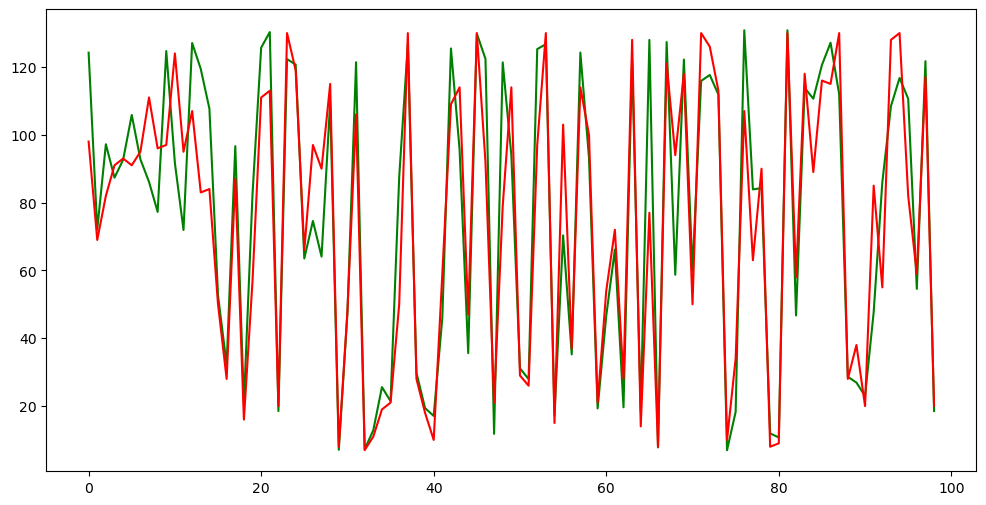

In [161]:
plt.figure(figsize=(12,6))
plt.plot(ypred_truc, color = 'g')
plt.plot(ytest_truc, color = 'r')
#plt.plot(n_samp)

<BarContainer object of 99 artists>

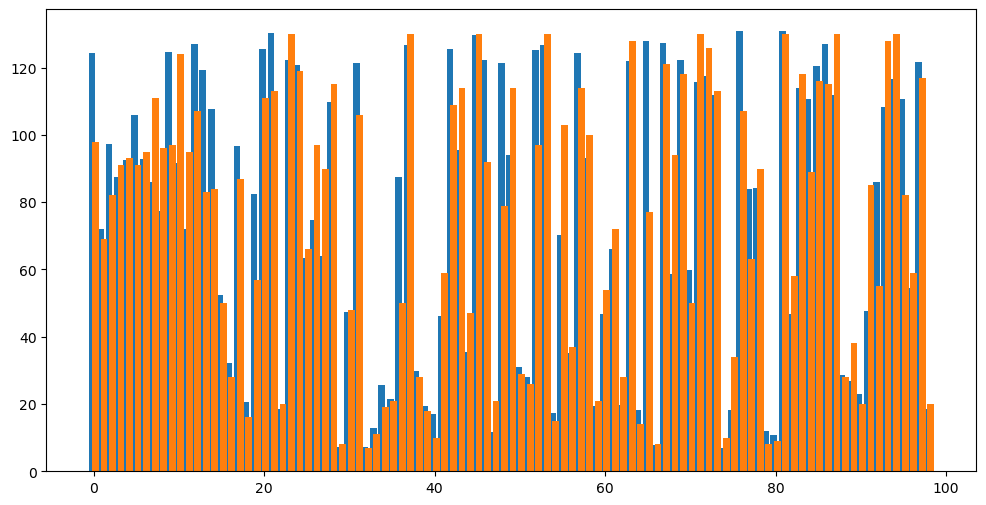

In [163]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(ytest_truc)) 
  
plt.bar(X_axis - 0.2, ypred_truc, label = 'Girls') 
plt.bar(X_axis + 0.2, ytest_truc,label = 'Boys') 
  
#plt.xticks(X_axis, X) 

In [134]:
ytest_truc[ypred_truc > 150].arg()

AttributeError: 'numpy.ndarray' object has no attribute 'arg'

In [132]:
np.round(ypred_truc[ypred_truc > 150])

array([158., 155., 169., 177., 184., 292., 244., 179.], dtype=float32)

In [136]:
np.where(ypred_truc > 150)

(array([ 0, 31, 42, 45, 63, 65, 81, 83], dtype=int64),)

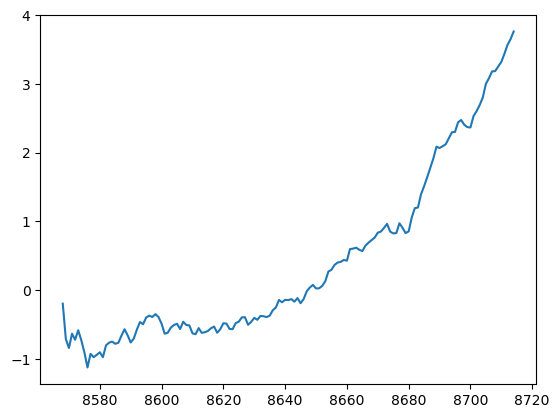

In [137]:
plt.plot(xtest_data[engine_test_data == 66]['PC1'])

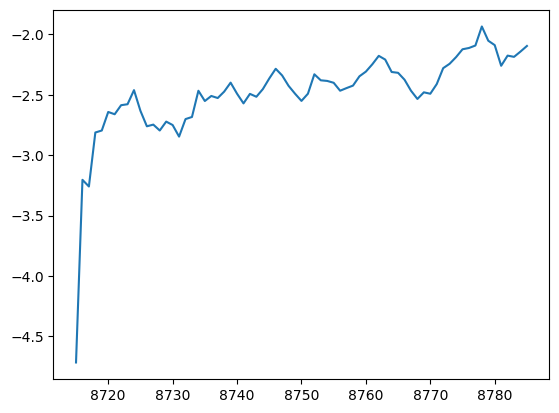

In [138]:
plt.plot(xtest_data[engine_test_data == 67]['PC1'])

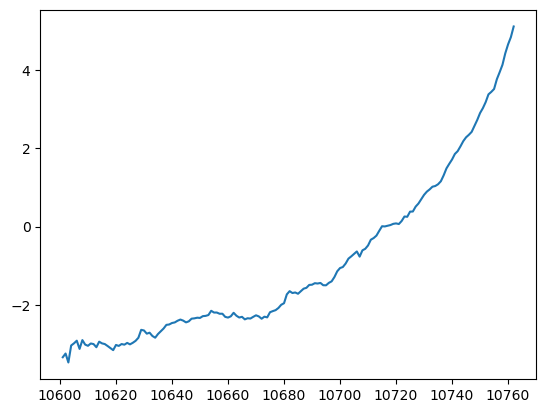

In [139]:
plt.plot(xtest_data[engine_test_data == 82]['PC1'])

In [140]:
ytrain_data

,Remaining Cycles
0,191
1,190
2,189
3,188
4,187
...,...
20626,4
20627,3
20628,2
20629,1
